In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle(1).json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle(1).json

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `cp kaggle(1).json ~/.kaggle/'
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `chmod 600 /root/.kaggle/kaggle(1).json'


In [3]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 88% 53.0M/60.3M [00:00<00:00, 180MB/s]
100% 60.3M/60.3M [00:00<00:00, 162MB/s]


In [4]:
!unzip "/content/fer2013.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [5]:
train_directory = "/content/train"
val_directory = "/content/test"
CLASS_NAMES = ['angry','disgust','fear','happy','neutral','sad','surprise']
CONFIGURATION = {
    "BATCH_SIZE":16,
    "IM_SIZE":48,
    "LEARNING_RATE":0.001,
    "N_EPOCHS":50,
    "DROPOUT_RATE":0.1,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":150,
    "N_DENSE_2":50,
    "NUM_CLASSES":7
}

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout,Layer,MaxPooling2D, GlobalAveragePooling2D, Add, Activation
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)


In [8]:
train_generator = train_datagen.flow_from_directory(directory = train_directory,
                                                    target_size = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = val_directory,
                                                              target_size = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation")

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [9]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def VGGnet(input_shape=(48, 48, 1), num_classes=7):
    inputs = layers.Input(shape=input_shape)

    # CONV BLOCK 1
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv_2')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)
    x = layers.Dropout(0.1)(x)

    # CONV BLOCK 2
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block2_pool')(x)
    x = layers.Dropout(0.1)(x)

    # CONV BLOCK 3
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block3_pool')(x)
    x = layers.Dropout(0.1)(x)

    # CONV BLOCK 4
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block4_pool')(x)
    x = layers.Dropout(0.1)(x)

    # CONV BLOCK 5
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), name='block5_pool')(x)
    x = layers.Dropout(0.1)(x)

    # FULLY CONNECTED LAYERS
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005), name='fully_connected_1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0005), name='fully_connected_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1)(x)

    # OUTPUT LAYER
    outputs = layers.Dense(7, activation='softmax', name='output')(x)

    model = models.Model(inputs, outputs, name='VGGnet')
    return model

# Example usage:
model = VGGnet(input_shape=(48, 48, 1), num_classes=7)
model.summary()


Model: "VGGnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv_2 (Conv2D)               │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv_1 (Conv2D)               │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv_1 (Conv2D)               │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv_1 (Conv2D)               │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv_1 (Conv2D)               │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,017,543 (15.33 MB)

 Trainable params: 4,013,831 (15.31 MB)

 Non-trainable params: 3,712 (14.50 KB)

In [11]:
from tensorflow.keras.optimizers import SGD
loss_function = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name='accuracy'),TopKCategoricalAccuracy(k=2,name='top_2_accuracy')]
for layer in model.layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
model.compile(
    optimizer = SGD(learning_rate=0.01, momentum=0.9),
    loss = loss_function,
    metrics = metrics
)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath="best_model_.h5",  # Save model as .h5 file
    monitor="val_accuracy",  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode="max",  # Maximize val_accuracy
    verbose=1
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor validation loss
    factor=0.5,  # Reduce LR by 50% when needed
    patience=3,  # Wait 3 epochs before reducing
    min_lr=1e-6,  # Minimum LR to avoid too slow training
    verbose=1  # Print when LR is reduced
)
history = model.fit(x = train_generator,epochs = 100,validation_data = validation_generator,callbacks=[checkpoint_callback,reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2418 - loss: 2.0260 - top_2_accuracy: 0.4136
Epoch 1: val_accuracy improved from -inf to 0.24721, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - accuracy: 0.2419 - loss: 2.0260 - top_2_accuracy: 0.4136 - val_accuracy: 0.2472 - val_loss: 1.9818 - val_top_2_accuracy: 0.4211 - learning_rate: 0.0100
Epoch 2/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2486 - loss: 1.9722 - top_2_accuracy: 0.4296
Epoch 2: val_accuracy did not improve from 0.24721
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.2486 - loss: 1.9722 - top_2_accuracy: 0.4296 - val_accuracy: 0.2472 - val_loss: 1.9588 - val_top_2_accuracy: 0.4358 - learning_rate: 0.0100
Epoch 3/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2503 - loss: 1.9475 - top_2_accuracy: 0.4385
Epoch 3: val_accuracy did not improve from 0.24721
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.2504 - loss: 1.9475 - top_2_accuracy: 0.4385 - val_accuracy: 0.2472 - val_loss: 1.9454 - val_top_2_accuracy: 0.4448 - learning_rate: 0.0100
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2524 - loss: 

359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.2524 - loss: 1.9335 - top_2_accuracy: 0.4443 - val_accuracy: 0.2528 - val_loss: 1.9125 - val_top_2_accuracy: 0.4567 - learning_rate: 0.0100
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2665 - loss: 1.9065 - top_2_accuracy: 0.4605
Epoch 5: val_accuracy improved from 0.25279 to 0.29330, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.2665 - loss: 1.9065 - top_2_accuracy: 0.4606 - val_accuracy: 0.2933 - val_loss: 1.8670 - val_top_2_accuracy: 0.4874 - learning_rate: 0.0100
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2900 - loss: 1.8734 - top_2_accuracy: 0.4862
Epoch 6: val_accuracy improved from 0.29330 to 0.34078, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.2900 - loss: 1.8734 - top_2_accuracy: 0.4862 - val_accuracy: 0.3408 - val_loss: 1.8027 - val_top_2_accuracy: 0.5237 - learning_rate: 0.0100
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3114 - loss: 1.8424 - top_2_accuracy: 0.5046
Epoch 7: val_accuracy did not improve from 0.34078
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.3114 - loss: 1.8424 - top_2_accuracy: 0.5046 - val_accuracy: 0.3408 - val_loss: 1.7791 - val_top_2_accuracy: 0.5328 - learning_rate: 0.0100
Epoch 8/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3283 - loss: 1.7904 - top_2_accuracy: 0.5297
Epoch 8: val_accuracy improved from 0.34078 to 0.38966, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.3283 - loss: 1.7904 - top_2_accuracy: 0.5297 - val_accuracy: 0.3897 - val_loss: 1.6896 - val_top_2_accuracy: 0.5887 - learning_rate: 0.0100
Epoch 9/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3603 - loss: 1.7357 - top_2_accuracy: 0.5523
Epoch 9: val_accuracy improved from 0.38966 to 0.42528, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.3603 - loss: 1.7356 - top_2_accuracy: 0.5524 - val_accuracy: 0.4253 - val_loss: 1.6177 - val_top_2_accuracy: 0.6110 - learning_rate: 0.0100
Epoch 10/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3910 - loss: 1.6714 - top_2_accuracy: 0.5842
Epoch 10: val_accuracy improved from 0.42528 to 0.43575, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.3910 - loss: 1.6714 - top_2_accuracy: 0.5842 - val_accuracy: 0.4358 - val_loss: 1.5753 - val_top_2_accuracy: 0.6257 - learning_rate: 0.0100
Epoch 11/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4073 - loss: 1.6257 - top_2_accuracy: 0.5982
Epoch 11: val_accuracy improved from 0.43575 to 0.44483, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.4073 - loss: 1.6257 - top_2_accuracy: 0.5983 - val_accuracy: 0.4448 - val_loss: 1.5353 - val_top_2_accuracy: 0.6292 - learning_rate: 0.0100
Epoch 12/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4210 - loss: 1.5819 - top_2_accuracy: 0.6139
Epoch 12: val_accuracy improved from 0.44483 to 0.45810, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.4211 - loss: 1.5818 - top_2_accuracy: 0.6140 - val_accuracy: 0.4581 - val_loss: 1.4837 - val_top_2_accuracy: 0.6620 - learning_rate: 0.0100
Epoch 13/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4365 - loss: 1.5252 - top_2_accuracy: 0.6358
Epoch 13: val_accuracy improved from 0.45810 to 0.46439, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.4365 - loss: 1.5252 - top_2_accuracy: 0.6358 - val_accuracy: 0.4644 - val_loss: 1.4646 - val_top_2_accuracy: 0.6459 - learning_rate: 0.0100
Epoch 14/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4551 - loss: 1.4899 - top_2_accuracy: 0.6542
Epoch 14: val_accuracy improved from 0.46439 to 0.50209, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.4551 - loss: 1.4899 - top_2_accuracy: 0.6543 - val_accuracy: 0.5021 - val_loss: 1.3839 - val_top_2_accuracy: 0.6934 - learning_rate: 0.0100
Epoch 15/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4772 - loss: 1.4420 - top_2_accuracy: 0.6693
Epoch 15: val_accuracy improved from 0.50209 to 0.52863, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.4772 - loss: 1.4419 - top_2_accuracy: 0.6693 - val_accuracy: 0.5286 - val_loss: 1.3296 - val_top_2_accuracy: 0.7151 - learning_rate: 0.0100
Epoch 16/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4937 - loss: 1.3935 - top_2_accuracy: 0.6913
Epoch 16: val_accuracy improved from 0.52863 to 0.54330, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.4937 - loss: 1.3935 - top_2_accuracy: 0.6914 - val_accuracy: 0.5433 - val_loss: 1.2978 - val_top_2_accuracy: 0.7304 - learning_rate: 0.0100
Epoch 17/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5059 - loss: 1.3633 - top_2_accuracy: 0.6987
Epoch 17: val_accuracy improved from 0.54330 to 0.54469, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5059 - loss: 1.3633 - top_2_accuracy: 0.6987 - val_accuracy: 0.5447 - val_loss: 1.2582 - val_top_2_accuracy: 0.7444 - learning_rate: 0.0100
Epoch 18/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5154 - loss: 1.3302 - top_2_accuracy: 0.7175
Epoch 18: val_accuracy did not improve from 0.54469
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.5154 - loss: 1.3302 - top_2_accuracy: 0.7175 - val_accuracy: 0.5279 - val_loss: 1.2734 - val_top_2_accuracy: 0.7367 - learning_rate: 0.0100
Epoch 19/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5313 - loss: 1.2959 - top_2_accuracy: 0.7291
Epoch 19: val_accuracy improved from 0.54469 to 0.56774, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.5313 - loss: 1.2959 - top_2_accuracy: 0.7291 - val_accuracy: 0.5677 - val_loss: 1.1999 - val_top_2_accuracy: 0.7605 - learning_rate: 0.0100
Epoch 20/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5333 - loss: 1.2666 - top_2_accuracy: 0.7360
Epoch 20: val_accuracy improved from 0.56774 to 0.58799, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.5333 - loss: 1.2667 - top_2_accuracy: 0.7360 - val_accuracy: 0.5880 - val_loss: 1.1782 - val_top_2_accuracy: 0.7709 - learning_rate: 0.0100
Epoch 21/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5488 - loss: 1.2476 - top_2_accuracy: 0.7460
Epoch 21: val_accuracy did not improve from 0.58799
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.5488 - loss: 1.2476 - top_2_accuracy: 0.7460 - val_accuracy: 0.5838 - val_loss: 1.1463 - val_top_2_accuracy: 0.7696 - learning_rate: 0.0100
Epoch 22/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5554 - loss: 1.2229 - top_2_accuracy: 0.7512
Epoch 22: val_accuracy did not improve from 0.58799
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.5553 - loss: 1.2230 - top_2_accuracy: 0.7512 - val_accuracy: 0.5810 - val_loss: 1.1543 - val_top_2_accuracy: 0.7696 - learning_rate: 0.0100
Epoch 23/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5595 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5865 - loss: 1.1574 - top_2_accuracy: 0.7754 - val_accuracy: 0.6054 - val_loss: 1.0924 - val_top_2_accuracy: 0.7884 - learning_rate: 0.0050
Epoch 26/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5920 - loss: 1.1140 - top_2_accuracy: 0.7853
Epoch 26: val_accuracy did not improve from 0.60545
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.5920 - loss: 1.1140 - top_2_accuracy: 0.7853 - val_accuracy: 0.6047 - val_loss: 1.0772 - val_top_2_accuracy: 0.7954 - learning_rate: 0.0050
Epoch 27/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5971 - loss: 1.1115 - top_2_accuracy: 0.7866
Epoch 27: val_accuracy did not improve from 0.60545
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.5971 - loss: 1.1115 - top_2_accuracy: 0.7866 - val_accuracy: 0.6020 - val_loss: 1.0818 - val_top_2_accuracy: 0.7954 - learning_rate: 0.0050
Epoch 28/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6103 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.6102 - loss: 1.0838 - top_2_accuracy: 0.7972 - val_accuracy: 0.6145 - val_loss: 1.0572 - val_top_2_accuracy: 0.8045 - learning_rate: 0.0050
Epoch 29/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5989 - loss: 1.1087 - top_2_accuracy: 0.7887
Epoch 29: val_accuracy improved from 0.61453 to 0.61941, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.5989 - loss: 1.1086 - top_2_accuracy: 0.7887 - val_accuracy: 0.6194 - val_loss: 1.0525 - val_top_2_accuracy: 0.8073 - learning_rate: 0.0050
Epoch 30/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6065 - loss: 1.0751 - top_2_accuracy: 0.7974
Epoch 30: val_accuracy did not improve from 0.61941
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6065 - loss: 1.0751 - top_2_accuracy: 0.7974 - val_accuracy: 0.6054 - val_loss: 1.0579 - val_top_2_accuracy: 0.7933 - learning_rate: 0.0050
Epoch 31/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6126 - loss: 1.0650 - top_2_accuracy: 0.8017
Epoch 31: val_accuracy did not improve from 0.61941
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.6126 - loss: 1.0650 - top_2_accuracy: 0.8016 - val_accuracy: 0.6131 - val_loss: 1.0600 - val_top_2_accuracy: 0.7933 - learning_rate: 0.0050
Epoch 32/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6168 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.6284 - loss: 1.0209 - top_2_accuracy: 0.8146 - val_accuracy: 0.6264 - val_loss: 1.0406 - val_top_2_accuracy: 0.8156 - learning_rate: 0.0050
Epoch 36/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6375 - loss: 1.0044 - top_2_accuracy: 0.8202
Epoch 36: val_accuracy did not improve from 0.62640

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.6375 - loss: 1.0045 - top_2_accuracy: 0.8202 - val_accuracy: 0.6131 - val_loss: 1.0702 - val_top_2_accuracy: 0.7968 - learning_rate: 0.0050
Epoch 37/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6440 - loss: 0.9923 - top_2_accuracy: 0.8255
Epoch 37: val_accuracy improved from 0.62640 to 0.63198, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.6440 - loss: 0.9922 - top_2_accuracy: 0.8255 - val_accuracy: 0.6320 - val_loss: 1.0177 - val_top_2_accuracy: 0.8142 - learning_rate: 0.0025
Epoch 38/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6467 - loss: 0.9810 - top_2_accuracy: 0.8313
Epoch 38: val_accuracy did not improve from 0.63198
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.6467 - loss: 0.9810 - top_2_accuracy: 0.8313 - val_accuracy: 0.6292 - val_loss: 1.0240 - val_top_2_accuracy: 0.8031 - learning_rate: 0.0025
Epoch 39/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6507 - loss: 0.9583 - top_2_accuracy: 0.8368
Epoch 39: val_accuracy improved from 0.63198 to 0.63687, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.6507 - loss: 0.9583 - top_2_accuracy: 0.8368 - val_accuracy: 0.6369 - val_loss: 1.0146 - val_top_2_accuracy: 0.8073 - learning_rate: 0.0025
Epoch 40/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6534 - loss: 0.9638 - top_2_accuracy: 0.8336
Epoch 40: val_accuracy improved from 0.63687 to 0.63757, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6534 - loss: 0.9638 - top_2_accuracy: 0.8336 - val_accuracy: 0.6376 - val_loss: 1.0095 - val_top_2_accuracy: 0.8059 - learning_rate: 0.0025
Epoch 41/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6574 - loss: 0.9471 - top_2_accuracy: 0.8390
Epoch 41: val_accuracy improved from 0.63757 to 0.64455, saving model to best_model_.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6574 - loss: 0.9471 - top_2_accuracy: 0.8390 - val_accuracy: 0.6446 - val_loss: 1.0069 - val_top_2_accuracy: 0.8135 - learning_rate: 0.0025
Epoch 42/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6583 - loss: 0.9445 - top_2_accuracy: 0.8409
Epoch 42: val_accuracy did not improve from 0.64455
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6583 - loss: 0.9445 - top_2_accuracy: 0.8409 - val_accuracy: 0.6376 - val_loss: 1.0052 - val_top_2_accuracy: 0.8045 - learning_rate: 0.0025
Epoch 43/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6736 - loss: 0.9235 - top_2_accuracy: 0.8469
Epoch 43: val_accuracy did not improve from 0.64455
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.6736 - loss: 0.9236 - top_2_accuracy: 0.8469 - val_accuracy: 0.6397 - val_loss: 1.0029 - val_top_2_accuracy: 0.8087 - learning_rate: 0.0025
Epoch 44/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6623 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.6623 - loss: 0.9418 - top_2_accuracy: 0.8403 - val_accuracy: 0.6508 - val_loss: 1.0003 - val_top_2_accuracy: 0.8122 - learning_rate: 0.0025
Epoch 45/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6609 - loss: 0.9325 - top_2_accuracy: 0.8383
Epoch 45: val_accuracy did not improve from 0.65084
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6610 - loss: 0.9325 - top_2_accuracy: 0.8383 - val_accuracy: 0.6334 - val_loss: 1.0171 - val_top_2_accuracy: 0.8115 - learning_rate: 0.0025
Epoch 46/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6632 - loss: 0.9213 - top_2_accuracy: 0.8426
Epoch 46: val_accuracy did not improve from 0.65084
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.6632 - loss: 0.9213 - top_2_accuracy: 0.8426 - val_accuracy: 0.6404 - val_loss: 0.9995 - val_top_2_accuracy: 0.8122 - learning_rate: 0.0025
Epoch 47/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6700 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6832 - loss: 0.8823 - top_2_accuracy: 0.8598 - val_accuracy: 0.6550 - val_loss: 0.9920 - val_top_2_accuracy: 0.8170 - learning_rate: 0.0012
Epoch 51/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6885 - loss: 0.8721 - top_2_accuracy: 0.8565
Epoch 51: val_accuracy did not improve from 0.65503
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.6886 - loss: 0.8721 - top_2_accuracy: 0.8565 - val_accuracy: 0.6411 - val_loss: 0.9989 - val_top_2_accuracy: 0.8170 - learning_rate: 0.0012
Epoch 52/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6891 - loss: 0.8781 - top_2_accuracy: 0.8594
Epoch 52: val_accuracy did not improve from 0.65503
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.6891 - loss: 0.8781 - top_2_accuracy: 0.8594 - val_accuracy: 0.6418 - val_loss: 1.0014 - val_top_2_accuracy: 0.8198 - learning_rate: 0.0012
Epoch 53/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6897 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.7098 - loss: 0.8261 - top_2_accuracy: 0.8744 - val_accuracy: 0.6585 - val_loss: 0.9879 - val_top_2_accuracy: 0.8254 - learning_rate: 3.1250e-04
Epoch 59/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7061 - loss: 0.8333 - top_2_accuracy: 0.8700
Epoch 59: val_accuracy did not improve from 0.65852
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.7061 - loss: 0.8333 - top_2_accuracy: 0.8700 - val_accuracy: 0.6515 - val_loss: 0.9906 - val_top_2_accuracy: 0.8247 - learning_rate: 3.1250e-04
Epoch 60/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7129 - loss: 0.8142 - top_2_accuracy: 0.8770
Epoch 60: val_accuracy did not improve from 0.65852
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.7129 - loss: 0.8142 - top_2_accuracy: 0.8770 - val_accuracy: 0.6487 - val_loss: 0.9904 - val_top_2_accuracy: 0.8212 - learning_rate: 3.1250e-04
Epoch 61/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy

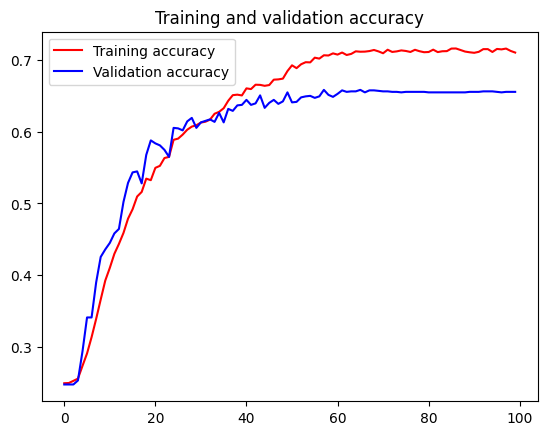

<Figure size 640x480 with 0 Axes>

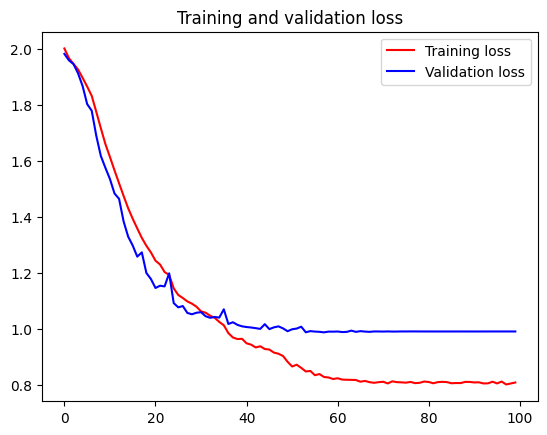

In [13]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()

In [14]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
train_loss, train_acc,train_top2_acc = model.evaluate(train_generator)
test_loss, test_acc,test_top2_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.7555 - loss: 0.7119 - top_2_accuracy: 0.9017
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6556 - loss: 0.9999 - top_2_accuracy: 0.8155
final train accuracy = 75.16 , validation accuracy = 65.57
